In [1]:
import sys
import os
import json
import time

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import mixed_precision

# Benchmark

In [ ]:
def _():
    # --- FONCTION DE TEST ---
    def benchmark(device_name, steps=10):
        print(f"\n--- Test sur {device_name} en cours... ---")
        with tf.device(device_name):
            # Création d'un modèle factice
            model_benchmark = MobileNetV2(weights=None, input_shape=(224, 224, 3), classes=120)
            model_benchmark.compile(optimizer='adam', loss='categorical_crossentropy')

            # Données factices
            fake_data = np.random.random((16, 224, 224, 3)).astype('float32')
            fake_labels = np.random.random((16, 120)).astype('float32')

            # Chauffe (Warm-up)
            model_benchmark.train_on_batch(fake_data, fake_labels)

            # Mesure
            start = time.time()
            for _ in range(steps):
                model_benchmark.train_on_batch(fake_data, fake_labels)
            end = time.time()

            avg_time = (end - start) / steps
            print(f"⏱️ Temps moyen par batch : {avg_time*1000:.1f} ms")
            return avg_time

    # --- RÉSULTATS ---
    t_cpu = benchmark('/CPU:0')
    t_gpu = benchmark('/GPU:0')

    print(f"\n🚀 ACCÉLÉRATION : Le GPU est {t_cpu/t_gpu:.1f}x plus rapide que le CPU !")

# _()

# Environnement

In [2]:
mixed_precision.set_global_policy('mixed_float16')
gpus = tf.config.list_physical_devices('GPU')

ROOT_DIRECTORY = Path.cwd().parent.parent
ETUDE_DIRECTORY = ROOT_DIRECTORY / 'Projet-Etude-CNN-DeepLearning'
DATASET_DIRECTORY = ETUDE_DIRECTORY / "dataset" / "Dog-Breed-Identification"
NOTEBOOKS_DIRECTORY = ETUDE_DIRECTORY / "notebooks"
MODELS_DIRECTORY = ETUDE_DIRECTORY / "models"

TRAIN_DATASET_FOLDER_JPG = DATASET_DIRECTORY / 'train'
TEST_DATASET_FOLDER_JPG = DATASET_DIRECTORY / 'test'
FEATURES_FILE_CSV = DATASET_DIRECTORY / 'labels.csv'

MODEL_NAME = "model_dog_from_scratch"
MODEL_CHECKPOINT_PATH = MODELS_DIRECTORY / MODEL_NAME / 'checkpoints' / f"{MODEL_NAME}_checkpoint.keras"
MODEL_FINAL_PATH = MODELS_DIRECTORY / MODEL_NAME / f"{MODEL_NAME}.keras"

print(f"""
ROOT_DIRECTORY : {ROOT_DIRECTORY}
ETUDE_DIRECTORY : {ETUDE_DIRECTORY}
DATASET_DIRECTORY : {DATASET_DIRECTORY}
NOTEBOOKS_DIRECTORY : {NOTEBOOKS_DIRECTORY}
MODELS_DIRECTORY : {MODELS_DIRECTORY}
TRAIN_DATASET_FOLDER_JPG : {TRAIN_DATASET_FOLDER_JPG}
TEST_DATASET_FOLDER_JPG : {TEST_DATASET_FOLDER_JPG}
FEATURES_FILE_CSV : {FEATURES_FILE_CSV}
MODEL_NAME : {MODEL_NAME}
MODEL_CHECKPOINT_PATH: {MODEL_CHECKPOINT_PATH}
MODEL_FINAL_PATH : {MODEL_FINAL_PATH}
""")


ROOT_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning
ETUDE_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning
DATASET_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/dataset/Dog-Breed-Identification
NOTEBOOKS_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/notebooks
MODELS_DIRECTORY : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/models
TRAIN_DATASET_FOLDER_JPG : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/dataset/Dog-Breed-Identification/train
TEST_DATASET_FOLDER_JPG : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/dataset/Dog-Breed-Identification/test
FEATURES_FILE_CSV : /home/leolchalot/Documents/Projets/CNN - Deep Learning/Projet-Etude-CNN-DeepLearning/dataset/Dog-Breed-Identification/labels.csv
MODEL_NAM

# Configuration matérielle

In [3]:
def show_available_configuration():
    """
    Show the current hardware configuration
    :return:
    """
    print(f"🐍 Version Python : {sys.version.split()[0]}")
    print(f"🤖 Version TensorFlow : {tf.__version__}")

    try:
        print("\n--- État Système (nvidia-smi) ---")
        !nvidia-smi
    except Exception as rised_error:
        print(rised_error)

    print("\n--- Détection TensorFlow ---")
    if not gpus:
        print("❌ Aucun GPU détecté par TensorFlow.")
        print("Causes possibles :")
        print("1. Vous n'avez pas installé 'tensorflow[and-cuda]'")
        print("2. Votre version de Python n'est pas supportée.")
        print("3. La variable CUDA_VISIBLE_DEVICES = -1 est restée active.")
    else:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ GPU configuré : Mémoire dynamique activée")
        except RuntimeError as rised_error:
            print(f"Erreur config GPU : {rised_error}")

show_available_configuration()

🐍 Version Python : 3.10.19
🤖 Version TensorFlow : 2.20.0

--- État Système (nvidia-smi) ---
Fri Jan 30 10:45:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8              2W /   80W |    1231MiB /   8188MiB |      0%      Default |
|                                         |     

# Chargement des données

In [4]:
images_train_dataset = os.listdir(TRAIN_DATASET_FOLDER_JPG)
images_test_dataset = os.listdir(TEST_DATASET_FOLDER_JPG)
labels_df = pd.read_csv(FEATURES_FILE_CSV)
print(' No# of train images in data:', len(images_train_dataset))
print(' No# of test images in data:', len(images_test_dataset))
labels_df.head()

 No# of train images in data: 10222
 No# of test images in data: 10357


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# Affichage des images du dataset

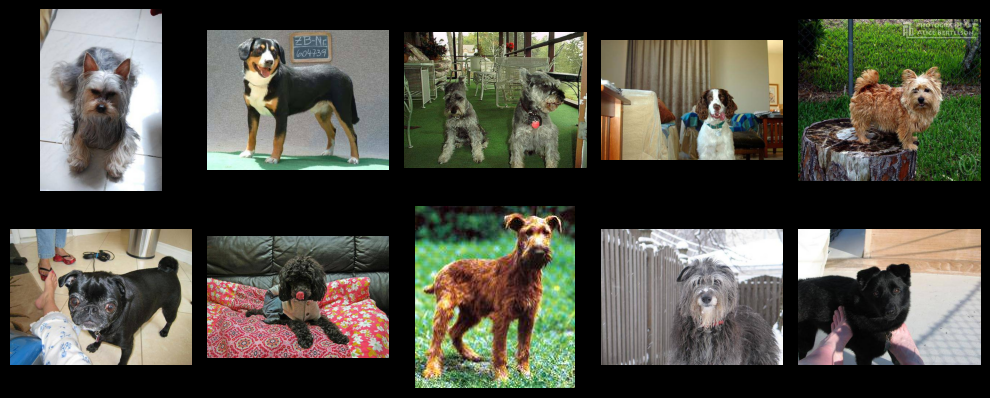

In [5]:
def display_n_images(dataset, n):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(5, 5, i+1)
        # 1. Récupérer le nom du fichier
        filename = dataset[i]
        # 2. Construire le chemin complet vers l'image
        img_path = os.path.join(TRAIN_DATASET_FOLDER_JPG, filename)
        # 3. Charger l'image réelle (les pixels)
        img = mpimg.imread(img_path)
        # 4. Afficher l'image
        plt.imshow(img)
        # 5. Récupérer le label correct
        img_id = filename.split('.')[0]
        plt.grid(False)
        plt.axis('off')
        try:
            label = labels_df.loc[labels_df['id'] == img_id, 'breed']
        except IndexError:
            label = "Inconnu"
        plt.xlabel(label, fontsize=8)
    plt.tight_layout()
    plt.show()

display_n_images(images_train_dataset, 10)

# Variables de Configuration

In [6]:
BATCH_SIZE = 16
RANDOM_SEED = 42
SHUFFLE = True
TARGET_SIZE = (224,224)

VALIDATION_SPLIT = 0.2      # 20% des données serviront à la validation
ROTATION_RANGE = 40         # Rotation aléatoire jusqu'à 20 degrés
WIDTH_SHIFT_RANGE = 0.2     # Décalage horizontal
HEIGHT_SHIFT_RANGE = 0.2    # Décalage vertical
HORIZONTAL_FLIP = True      # Retournement horizontal (miroir)
FILL_MODE = "nearest"       # Methode de remplissage des pixels "éteints"

# Reconstitution des noms des fichiers d'images
labels_df['id'] = labels_df['id'].apply(lambda x: x + ".jpg" if not x.endswith(".jpg") else x)

# print(labels_df.head())

# Configuration de l'entraînement

In [7]:
# Création du générateur avec augmentation de données
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

# Configuration pour l'entraînement avec augmentation de données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    fill_mode=FILL_MODE
)

# Configuration pour la validation
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Entraînement
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=TRAIN_DATASET_FOLDER_JPG,
    x_col="id",
    y_col="breed",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    shuffle=SHUFFLE,
    class_mode="categorical",
    target_size=TARGET_SIZE
)

# Validation
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=TRAIN_DATASET_FOLDER_JPG,
    x_col="id",
    y_col="breed",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    shuffle=SHUFFLE,
    class_mode="categorical",
    target_size=TARGET_SIZE
)

# ---- Configuration du déroulement de l'entraînement ----
# 1. Sauvegarde
checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_PATH,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# 2. Arrêt automatique (Patience augmentée à 8, car l'apprentissage from scratch est lent)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=8,
                           restore_best_weights=True)

# 3. Ralentissement automatique (INDISPENSABLE ici)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,    # On divise le Learning Rate par 5
                              patience=3,    # Si pas d'amélioration pendant 3 époques
                              min_lr=1e-6,   # Ne pas descendre trop bas
                              verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

# print(train_generator.class_indices)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


# Architecture du modèle

$Convolution : Sortie = (Poids × Entrée) + Biais_conv$

Pas besoin de spécifier de biais sur les couches de convolution
Si on utilise un biais dans la convolution :

$(x + Biais_conv) − Moyenne = (x − Moyenne) + (Biais_conv − Biais_conv)$

Enchaînement d'opérations :
- Conv2D : Extraction des caractéristiques (Calcul lourd).
- BatchNormalization : Stabilisation et recentrage (Prépare les données).
- Activation (ReLU) : Décision non-linéaire (Garde l'info utile, jette le reste).
- Dropout / Pooling : Régularisation ou réduction de dimension.

In [8]:
N_CLASSES = len(train_generator.class_indices)
INPUT_SHAPE = (224, 224, 3)
METRICS = ['accuracy']
LOSS = 'categorical_crossentropy'
OPTIMIZER = 'adam'

def build_advanced_model(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)

    # --- BLOC SQUEEZE-EXCITATION (Attention) ---
    def se_block(x_se, filters, ratio=16):
        # Réduit l'image à 1x1 pixel par canal (moyenne générale)
        se = layers.GlobalAveragePooling2D()(x_se)
        # Compression
        se = layers.Dense(filters // ratio, activation='relu', use_bias=False)(se)
        # Étirement et application de sigmoid (poids entre 0 et 1)
        se = layers.Dense(filters, activation='sigmoid', use_bias=False)(se)
        # Canaux d'origine * poids
        return layers.Multiply()([x_se, se])

    # --- BLOC RÉSIDUEL COMPLET ---
    def res_conv_block(x_res, filters, stride=1):
        shortcut = x_res
        # 1. Gestion du raccourci (Shortcut)
        if stride > 1 or x_res.shape[-1] != filters:
            shortcut = layers.Conv2D(
                filters,
                (1, 1),
                strides=stride,
                use_bias=False,
                kernel_regularizer=regularizers.l2(1e-4))(x_res)

            shortcut = layers.BatchNormalization()(shortcut)

        # 2. Branche principale (Convolution A)
        x_res = layers.Conv2D(
            filters,
            (3, 3),
            strides=stride,
            padding='same',
            use_bias=False,
            kernel_regularizer=regularizers.l2(1e-4))(x_res)

        x_res = layers.BatchNormalization()(x_res)
        x_res = layers.Activation('swish')(x_res)
        # 3. Branche principale (Convolution B)
        x_res = layers.Conv2D(
            filters,
            (3, 3),
            padding='same',
            use_bias=False,
            kernel_regularizer=regularizers.l2(1e-4))(x_res)

        x_res = layers.BatchNormalization()(x_res)
        # 4. Intégration de l'Attention (SE Block)
        x_res = se_block(x_res, filters)
        # 5. Skip Connection
        x_res = layers.Add()([x_res, shortcut])
        x_res = layers.Activation('swish')(x_res) # Activation finale du bloc

        return x_res

    # --- DÉBUT DE L'ARCHITECTURE ---
    # Convolution initiale
    x = layers.Conv2D(32, (3, 3), strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # --- EMPILEMENT DES BLOCS ---
    x = res_conv_block(x, 64, stride=2)   # Réduit la taille /2
    x = res_conv_block(x, 64, stride=1)   # Garde la taille (plus de profondeur)

    x = res_conv_block(x, 128, stride=2)
    x = res_conv_block(x, 128, stride=1)

    x = res_conv_block(x, 256, stride=2)
    x = res_conv_block(x, 256, stride=1)

    x = res_conv_block(x, 512, stride=2)
    x = res_conv_block(x, 512, stride=1)

    # --- TÊTE DU RÉSEAU ---
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(
        n_classes,
        activation='softmax'
    )(x)
    return models.Model(inputs, outputs)

# Création
model = build_advanced_model(INPUT_SHAPE, N_CLASSES)

# Compilation
model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=METRICS)

model.summary()

I0000 00:00:1769766334.197955   35862 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4939 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,432 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,864 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      2,048 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 112, 112,  │          0 │ multiply[0][0],   │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,309,912 (43.14 MB)

 Trainable params: 11,300,248 (43.11 MB)

 Non-trainable params: 9,664 (37.75 KB)

# Entraînement du modèle

In [ ]:
# 4. Lancement (50 EPOCHS)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=callbacks_list
)

# Visualisation du déroulement de l'entraînement

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Courbe de Précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entraînement Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Précision (Accuracy)')

# Courbe de Perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entraînement Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Perte (Loss)')
plt.show()

# Sauvegarde du modèle

In [ ]:
# Sauvegarde au format de Keras
model.save(MODEL_FINAL_PATH)
print("Modèle sauvegardé avec succès !")

# Test de prédiction

In [ ]:
labels_map = {v: k for k, v in train_generator.class_indices.items()}

def predict_breed(img_path):
    # Charger l'image et la redimensionner comme à l'entraînement (224x224)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convertir en tableau de nombres (array)
    img_array = image.img_to_array(img)
    
    # Normaliser (diviser par 255 comme lors de l'entraînement)
    img_array = img_array / 255.0
    
    # Ajouter une dimension pour simuler un batch de 1 image (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Faire la prédiction
    predictions = model.predict(img_array)
    
    # Trouver l'index de la probabilité la plus élevée
    predicted_class_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    
    predicted_breed = labels_map[predicted_class_index]
    
    # Affichage
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prédiction : {predicted_breed} ({confidence:.2f}%)")
    plt.show()

# --- UTILISATION ---
# Remplacez par le chemin d'une image de votre dossier de test
test_image_path = os.path.join(TEST_DATASET_FOLDER_JPG, os.listdir(TEST_DATASET_FOLDER_JPG)[3])
predict_breed(test_image_path)

# Dump des labels
Utilisé ensuite depuis l'application web afin de relier les ID aux labels

In [ ]:
# Récupérer le mapping ({'beagle': 0, 'boxer': 1})
class_indices = train_generator.class_indices

# Inverser pour avoir {0: 'beagle', 1: 'boxer'}
idx_to_class = {v: k for k, v in class_indices.items()}

# Sauvegarder dans un fichier
with open(DATASET_DIRECTORY / 'class_indices.json', 'w') as f:
    json.dump(idx_to_class, f)

print("✅ Fichier class_indices.json généré !")